# Corpus and BGRF Composition

We describe and analyse the status quo of the corpus with respect to criteria like author gender, year of first publication, narrative form etc. Then we compare it to the "baseline" of the Bibliographie du genre romanesque français, 1751-1800 (BGRF).

**Table of Contents**
* [Prerequisites](#Prerequisites)
  - [Import](#Import-all-necessary-python-libraries)
  - [Load corpus Metadata](#Corpus-Metadata)
  - [BGRF Metadata from Wikibase](#BGRF-Metadata-from-Wikibase)
    - [Configuration](#Configuration)
    - [Data Loading](#Data-Loading)
* [Author Gender](#Author-gender)
  - [Author Gender corpus](#Author-Gender-Corpus)
  - [Author Gender BGRF](#Author-Gender-(BGRF))
  - [Comparison](#comparison-by-decades)
* [Publication Date](#Publication-date)
  - [Publication Date](#Year-of-first-publication)
  - [Publication Date](#Publication-Date-(BGRF))
  - [Comparison](#Publication-Date-(Corpus-vs-BGRF))
* [Narrative Form](#Narrative-Form)
  - [Narrative Form corpus](#Narrative-Form-corpus)
  - [Narrative Form](#Narrative-Form-(BGRF))
  - [Comparison](#Narrative-Form-(Corpus-vs-BGRF))

## Prerequisites

### Import all necessary python libraries

In [443]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import seaborn as sns
sns.set()

# Install with e.g. `pip install sparqlwrapper`
from SPARQLWrapper import SPARQLWrapper, JSON

# Make plots appear directly in the notebook.
%matplotlib inline

from pprint import pprint

import gender_guesser.detector as gg
import re

The later parts also require access to a Wikibase instance, which is only accessible in/over the university network.

### Corpus Metadata

In [444]:
# Adjust the URL to the .tsv file as needed.
DATA_URL = 'https://raw.githubusercontent.com/MiMoText/roman18/master/XML-TEI/xml-tei_full_metadata.tsv'
xml_tei_metadata = pd.read_csv(DATA_URL, sep='\t')
print('Available column names:', xml_tei_metadata.columns.values)
print("amount of texts in corpus: ", len(xml_tei_metadata))

Available column names: ['filename' 'au-name' 'au-birth' 'au-death' 'title' 'au-gender'
 'firsted-yr' 'printSource-yr' 'form' 'spelling' 'data-capture'
 'token count' 'size' 'bgrf' 'author_wikidata' 'title_wikidata' 'lang'
 'publisher' 'distributor' 'distribution_date' 'copyright_status'
 'digitalSource_Title' 'digitalSource_Ref' 'digitalSource_Publisher'
 'digitalSource_Date' 'printSource_title' 'printSource_author'
 'printSource_pubPlace' 'printSource_date' 'resp_datacapture'
 'resp_encoding']
amount of texts in corpus:  179


Some of the metadata is not necessary for the script, so we can drop those columns to size down the DataFrame a little bit.

In [445]:
xml_tei_metadata.drop(columns=['data-capture', 'lang', 'distributor','distribution_date', 'copyright_status','resp_datacapture', 'resp_encoding',
    "au-birth", "au-death", "spelling", 'author_wikidata', 'title_wikidata', 'publisher', 'digitalSource_Title', 'digitalSource_Ref', 'digitalSource_Publisher',
    'digitalSource_Date', 'printSource_title', 'printSource_author'], inplace=True)

print('Available column names:', xml_tei_metadata.columns.values)

Available column names: ['filename' 'au-name' 'title' 'au-gender' 'firsted-yr' 'printSource-yr'
 'form' 'token count' 'size' 'bgrf' 'printSource_pubPlace'
 'printSource_date']


### BGRF Metadata from Wikibase
Data is pulled from Wikibase. For the moment, our instance on port 53100 is used. This may change in the future, which then will not only affect the URL but also the IDs of the items and predicates. Adjust these accordingly in the [Configuration Section](#Configuration).

#### Configuration

In [446]:
# Adjust these values whenever another Wikibase instance is to be used.
WB_URL = 'http://zora.uni-trier.de:11100'
ITEM_IDS = {
    'publication_date': 'P7',
    'author' : 'P5',
    'publication_date_str': 'P42',  # hard to use, since not normalized
    'sex_or_gender': 'P28',
    'narrative_form': 'P54',        # the wikibase label is "narrative perspective"
    'narrative_form_str': 'P46',    # the wikibase label is "narrative perspective_string"
    'page_count': 'P34',            # the wikibase label is "number of pages"
    'page_count_str': 'P44',        # the wikibase label is "number of pages_string"
    'distribution_format_str': 'P45',
    'distribution_format': 'P37',
    'bgrf_id': 'P13'
}

#### Data Loading

We use the SPARQL endpoint to query the bibliography metadata. Each metadatum gets its own query for simplicity's sake.

In [447]:
bgrf = pd.DataFrame()
wb_endpoint = f'{WB_URL}/proxy/wdqs/bigdata/namespace/wdq/sparql'

def get_data(endpoint, query):
    '''Given an endpoint URL and a SPARQL query, return
    the data as JSON.
    '''
    user_agent = 'jupyter notebook'
    sparql = SPARQLWrapper(endpoint, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()["results"]["bindings"]

This wrapper function conveniently provides the data as python dictionaries.
For example, to get all the data values for the property `narrative_form_str`,
we can use the following:


In [448]:
ex_query = 'SELECT DISTINCT ?form WHERE { ?item wdt:P46 ?form. }'
results = get_data(wb_endpoint, ex_query)
print('Number of distinct values:', len(results))
print('Each entry has the following form (NPI):', results[0])

Number of distinct values: 256
Each entry has the following form (NPI): {'form': {'xml:lang': 'fr', 'type': 'literal', 'value': '1re personne'}}


The key `'form'` corresponds to us choosing `?form` as the output variable in our SPARQL query.

In [449]:
# get the most important items from wikibase here
"""
# Query as it would be in sparql
SELECT ?authorLabel ?pubdate ?bgrf ?page_count ?narrLabel
WHERE {
  ?item wdt:P5 ?author; wdt:P7 ?pubdate; wdt:P13 ?bgrf.
  OPTIONAL { ?item wdt:P44 ?page_count; wdt:P54 ?narr.}
  SERVICE wikibase:label {bd:serviceParam wikibase:language "{AUTO_LANGUAGE}","en" .}}
"""
# Transformed to python
query_wikibase = ''.join([
    'SELECT ?authorLabel ?year ?bgrf_id ?page_count ?narrLabel ',
    'WHERE {',
    '?item wdt:', ITEM_IDS['author'], ' ?author; wdt:', ITEM_IDS['publication_date'], ' ?pubdate; wdt:', ITEM_IDS['bgrf_id'], ' ?bgrf_id',
    ' BIND(YEAR(?pubdate) as ?year).', 
    'OPTIONAL { ?item wdt:', ITEM_IDS['page_count_str'], ' ?page_count; wdt:', ITEM_IDS['narrative_form'], ' ?narr.}',
    'SERVICE wikibase:label',
    '{bd:serviceParam wikibase:language "{AUTO_LANGUAGE}","en" .}}'
])
wikibase = get_data(wb_endpoint, query_wikibase)
wikibase_df = pd.json_normalize(wikibase)

In [450]:
print(wikibase_df.columns)
wikibase_df.drop(columns=['page_count.xml:lang', 'page_count.type', 'bgrf_id.type', 'year.datatype', 'year.type','authorLabel.xml:lang',
    'authorLabel.type', 'narrLabel.xml:lang', 'narrLabel.type'], inplace=True)

wikibase_df.rename(columns={'year.value':"year"}, inplace=True)
wikibase_df["form"] = wikibase_df["narrLabel.value"]
print(wikibase_df.columns)


Index(['page_count.xml:lang', 'page_count.type', 'page_count.value',
       'bgrf_id.type', 'bgrf_id.value', 'year.datatype', 'year.type',
       'year.value', 'authorLabel.xml:lang', 'authorLabel.type',
       'authorLabel.value', 'narrLabel.xml:lang', 'narrLabel.type',
       'narrLabel.value'],
      dtype='object')
Index(['page_count.value', 'bgrf_id.value', 'year', 'authorLabel.value',
       'narrLabel.value', 'form'],
      dtype='object')


#### Add additional data

In [451]:
# copy dataframes to leave them untouched
wikibase_data = wikibase_df.copy()
corpus = xml_tei_metadata.copy()

## add origin as column for cominations later
corpus["origin"] = "corpus"
wikibase_data["origin"] = "wikibase"

In [452]:
## Add gender to wikibase

# NOTE: currently no data in Wikibase at :11100, so we use the gender detector to get the genders.

dec = gg.Detector()
# get author gender based on the first name of the authors

wikibase_data["pred_gender"] = ""
wikibase_data["prename_new"] = ""

# for gender-guesser we only need the prenam
for i, au in wikibase_data['authorLabel.value'].iteritems():
    try:
        prename = au
        prename = prename.strip()  #remove whitespaces
        if re.search("madame", prename) or re.search("mademoiselle", prename) or re.search("comtesse", prename) or re.search("baronne", prename) or re.search("marquise", prename):
            wikibase_data["prename_new"].loc[i] = prename
            wikibase_data["pred_gender"].loc[i] = "female" 
        elif re.search("abbé", prename) or re.search("avocat", prename) or re.search("chevalier", prename) or re.search("baron", prename) or re.search("comte", prename) or re.search("marquis", prename) or re.search("père", prename) or re.search("duc", prename):
            wikibase_data["prename_new"].loc[i] = prename
            wikibase_data["pred_gender"].loc[i] = "male" 
        else:
            prename = au.split(',')[1].split('-')[0]
            if re.search(" É", prename):
                prename = re.sub("É", "E", prename) # Étienne not in gg, but Etienne is
            prename = prename.replace("dom", "")
            prename = prename.strip()
            wikibase_data["prename_new"].loc[i] = prename
            if re.search(" de", prename) and len(list(prename.strip())) != 2:
                prename = prename.strip().split(" ")[0]
                wikibase_data["prename_new"].loc[i] = prename
            elif len(list(prename.strip())) == 2: #re.search("d’", prename) and 
                wikibase_data["pred_gender"].loc[i] = "unknown"
            elif len(prename.strip().split(" ")) > 1:
                prename = prename.strip().split(" ")[0]
                wikibase_data["prename_new"].loc[i] = prename
    except IndexError:
        prename = au
        wikibase_data["prename_new"].loc[i] = prename
        wikibase_data["pred_gender"].loc[i] = "unknown"

for i, au in wikibase_data.iterrows():
    if au["pred_gender"] == "":
        gender = dec.get_gender(au["prename_new"].strip())
        wikibase_data["pred_gender"].loc[i] = gender
    #print(gender)
wikibase_data["pred_gender"] = wikibase_data["pred_gender"].map(lambda x: "male" if x == "mostly_male" else x )
wikibase_data["pred_gender"] = wikibase_data["pred_gender"].map(lambda x: "unknown" if x == "andy" else x )
wikibase_data.drop(columns=["prename_new"], inplace=True)
print(wikibase_data["pred_gender"].value_counts())
print("Number of rows in wikibase data: ", len(wikibase_data))

male       900
female     237
unknown    138
Name: pred_gender, dtype: int64
Number of rows in wikibase data:  1275


In [453]:
# map F as female, M as male and U as unknown in corpus to match with detected String labels from gender detector
corpus["gender"] = corpus["au-gender"]
corpus["gender"] = corpus["gender"].map(lambda x: "female" if x == "F" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "male" if x == "M" else x)
corpus["gender"] = corpus["gender"].map(lambda x: "unknown" if x == "U" else x)

### Combine wikidata and metadata-Table to one table

##### Choose year and Add decades

As not all dates of publication within the metadata and BGRF match exactly, you can choose whether to use the "firsted-yr" or the year based on the BGRF as first publication date.

In [454]:
#pubyear = pd.to_datetime(corpus['firsted-yr'], format='%Y')

## add year based on bgrf because it can differ from firsted-yr (see xxx)
# with only the first two digits of the bgrf which represent the years of the first publication
# if it does not have a bgrf we cast it as 1801

corpus["bgrf_year"] = corpus["bgrf"].map(lambda x: int(x.split(".")[0]) if x != "0" else 1)
corpus["bgrf_year"] = corpus["bgrf_year"].map(lambda x: 1700+x if x in range(50,100) else 1800+x)


#corpus["bgrf_year"] = pd.to_datetime(corpus['bgrf_year'], format='%Y')

#corpus["firsted-yr"] = pd.to_datetime(corpus['firsted-yr'], format='%Y')

# cast bgrf year as int 
corpus = corpus.astype({'bgrf_year': 'int32', 'firsted-yr':'str'})
corpus["firsted-yr"] = corpus["firsted-yr"].map(lambda x: int(x.split(".")[0]) if x != "nan" else x)

def map_decades(dataframe, year_col):
    decades_to_map = [(1750, 1759, "1750er"), (1760, 1769, "1760er"), (1770, 1779, "1770er"), (1780, 1789, "1780er"), (1790, 1799, "1790er"), (1800, "1800")]
    for dec in decades_to_map:
        if len(dec) == 3:
            dataframe.loc[(dataframe[year_col].between(dec[0], dec[1])), "decade"] = dec[2]
        else:
            dataframe.loc[(dataframe[year_col]==dec[0]), "decade"] = dec[1]
    return dataframe

def choose_year(dataframe, year_col, years_chosen):
    dataframe[year_col] = dataframe[years_chosen]
    return dataframe

#corpus = map_decades(corpus, "firsted-yr")
corpus = choose_year(corpus, "year", "bgrf_year")  # bgrf_year or firsted-yr

wikibase_data = wikibase_data.astype({'year': 'int32'})
wikibase_data = map_decades(wikibase_data, "year")

combined = pd.concat([corpus, wikibase_data.rename(columns={"pred_gender":"gender", "bgrf-id": "bgrf"})], ignore_index=True)
print(combined)


                filename                               au-name  \
0           Abbes_Voyage        Abbes de Cabreroles, Guillaume   
1     AndreSerieys_Comte  Jean-François André, Antoine Sérieys   
2           Anonym_Suzon                                Anonym   
3          Anonyme_Venus                               Anonyme   
4          Anonyme_Zoloe                                Anonym   
...                  ...                                   ...   
1449                 NaN                                   NaN   
1450                 NaN                                   NaN   
1451                 NaN                                   NaN   
1452                 NaN                                   NaN   
1453                 NaN                                   NaN   

                                                  title au-gender firsted-yr  \
0                               Voyage dans les espaces         M       1758   
1     Le comte d'A*** ou les aventures d'un jeu

## Author Gender


### Author Gender Corpus
Data is in the column 'au-gender'. Possible values are 'F', 'M' and 'U'.

Set of all occuring values: {'F', 'U', 'M'}
Percent of all genders in corpus 
 M    0.816
F    0.168
U    0.017
Name: au-gender, dtype: float64
Percent of all genders in corpus 
 M    146
F     30
U      3
Name: au-gender, dtype: int64


Text(0, 0.5, 'Count in corpus')

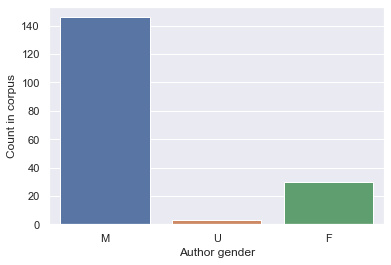

In [455]:
print('Set of all occuring values:', set(corpus["au-gender"].values))
print("Percent of all genders in corpus \n",corpus["au-gender"].value_counts(normalize=True).round(3))
print("Percent of all genders in corpus \n",corpus["au-gender"].value_counts().round(3))
## Visualization in total counts:
sns.countplot(x=corpus["au-gender"])
plt.xlabel('Author gender')
plt.ylabel('Count in corpus')

<AxesSubplot:xlabel='au-gender', ylabel='per'>

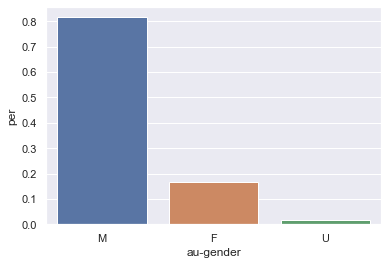

In [456]:
# Visualization in percent
corpus_gender_per = corpus["au-gender"].value_counts(normalize=True).round(3).reset_index()
corpus_gender_per.columns = ["au-gender", "per"]
sns.barplot(data=corpus_gender_per, x="au-gender", y="per")

### Author Gender (BGRF)


  pred_gender    per
0        male  0.706
1      female  0.186
2     unknown  0.108


Text(0, 0.5, 'Percent in wikidata')

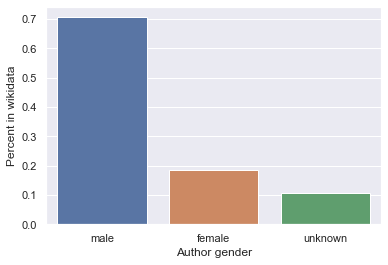

In [457]:
wikibase_gender_per = wikibase_data["pred_gender"].value_counts(normalize=True).round(3).reset_index()
wikibase_gender_per.columns = ["pred_gender", "per"]

print(wikibase_gender_per)
sns.barplot(data=wikibase_gender_per, x="pred_gender", y="per")
plt.xlabel('Author gender')
plt.ylabel('Percent in wikidata')


### Comparison

#### Comparison of gender proportion in corpus and in wikibase


Text(0, 0.5, 'proportion')

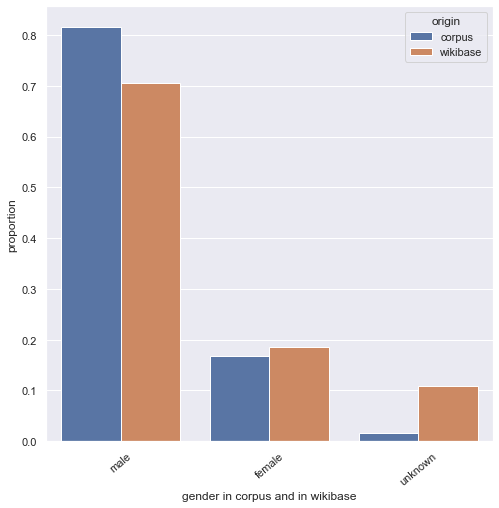

In [458]:
authors_new = wikibase_data.copy()
corpus_new = corpus.copy()

#combined = pd.concat([corpus_new,authors_new.rename(columns={"pred_gender":"gender"})], ignore_index=True)

authors_combined = combined[["origin",  "gender", "decade"]]

authors_grouped = authors_combined.groupby(["origin"])["gender"].value_counts(normalize=True).reset_index(name="percentage")

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x="gender", y="percentage", hue="origin", data=authors_grouped)
plt.xticks(rotation=40)
plt.xlabel("gender in corpus and in wikibase")
plt.ylabel("proportion")

We can see that the "unknown" annotated genders in the wikibase is quite high; that results of many authors that do not have a prename or a title like "comte" or "comtesse" which we covered in the previous part.
So for a "better" comparison we could remove all unknown gender data. This we will do in the following part where the genders will be compared within the decades.

#### Comparison by decades

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15448\4248401110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors_combined["gy"] = combined["gender"] + "-" + combined["decade"]


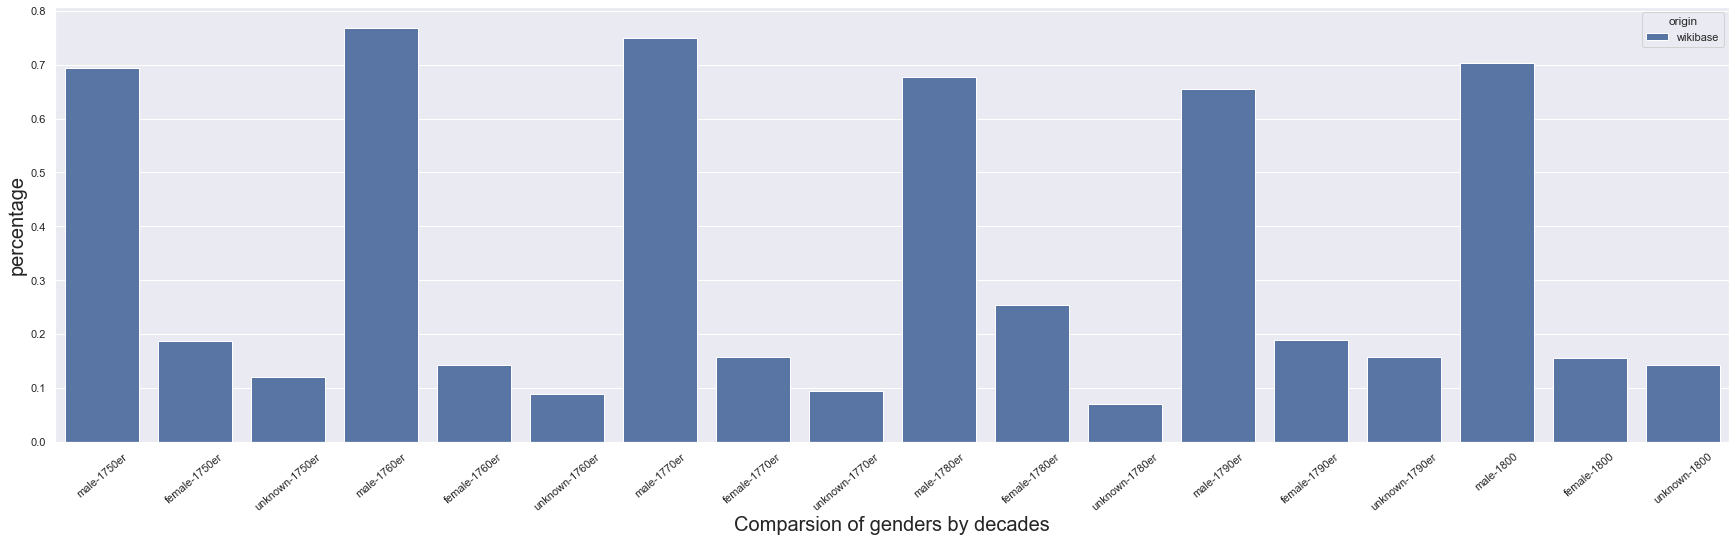

In [459]:
authors_combined["gy"] = combined["gender"] + "-" + combined["decade"]

#authors_decades = authors_combined[["decade", "origin", "gy", "gender"]]

authors_decades = authors_combined.groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")

# plot the data
def plot_author_decade(author_data):
    fig, ax = plt.subplots(figsize=(30,8))
    ax = sns.barplot(x="gy", y="percentage", hue="origin", data=author_data)
    plt.xticks(rotation=40)
    plt.xlabel("Comparsion of genders by decades", fontsize=20)
    plt.ylabel("percentage", fontsize=20)

plot_author_decade(authors_decades)


As we can see, the "unknown" gender in the xml-tei-corpus is so small that it is not quite visible in the visualization. Also the gender in the wikibase is based on the gender-guesser who cannot map all of the authors' names (e.g. only surnames etc.).
So in the following visualization we will drop the "unknown".

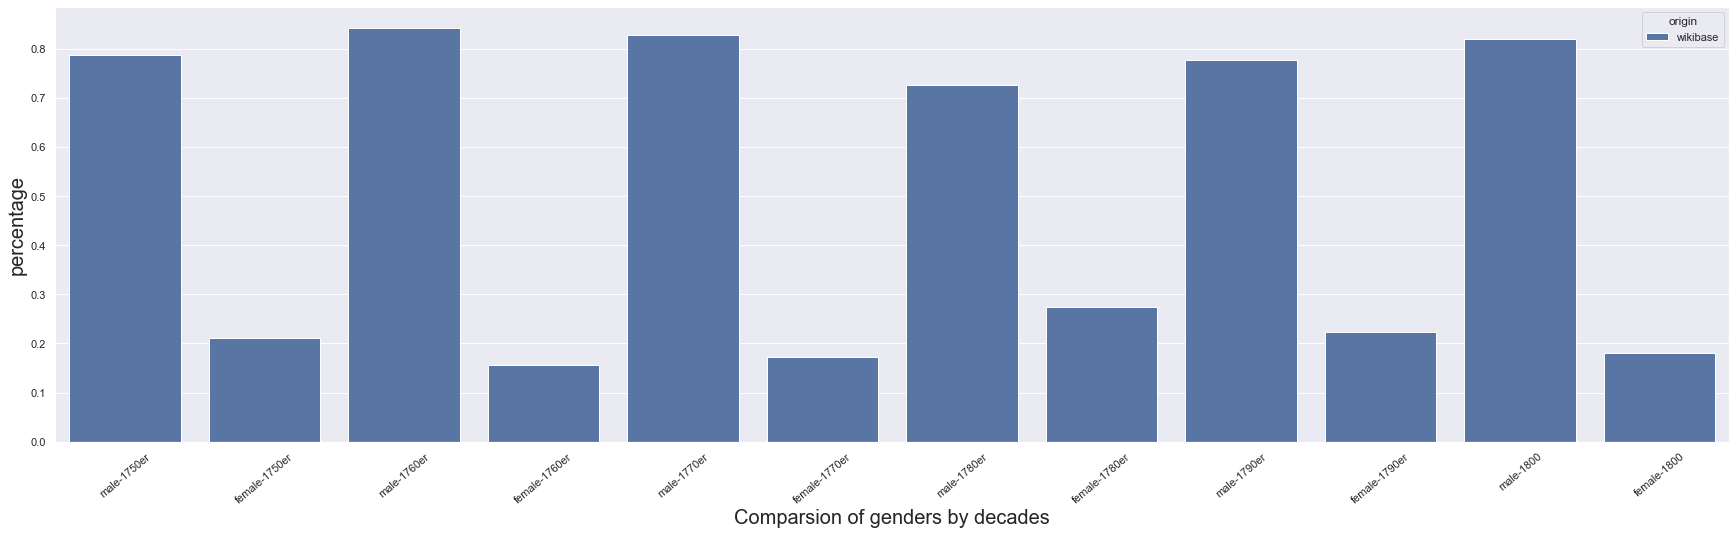

In [460]:
authors_wo_unknown = authors_combined.drop(authors_combined[(authors_combined["gender"] == "unknown")].index)

authors_wo_unknown = authors_wo_unknown.groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
plot_author_decade(authors_wo_unknown)


## Publication Date

### Corpus Year of first publication
Data is in the column 'firsted-yr'. However, possible values can be single years `(yyyy)`, year spans `(yyyy-yyyy)`, the floating point number value `NaN`, or even a string like `'unknown'`. Therefore, we need to clean up a bit before we can use it. In case of year ranges, we simply use the first year.

If we run the cell below, we can check the first edition year and the bgrf numbers, where we will see that they differ a little bit, which can be caused by different sources of the first year information. Also there are few texts in the corpus that are not listed in the Bibliographie as novels, but we considered as interesting. For comparison though we will drop those now.

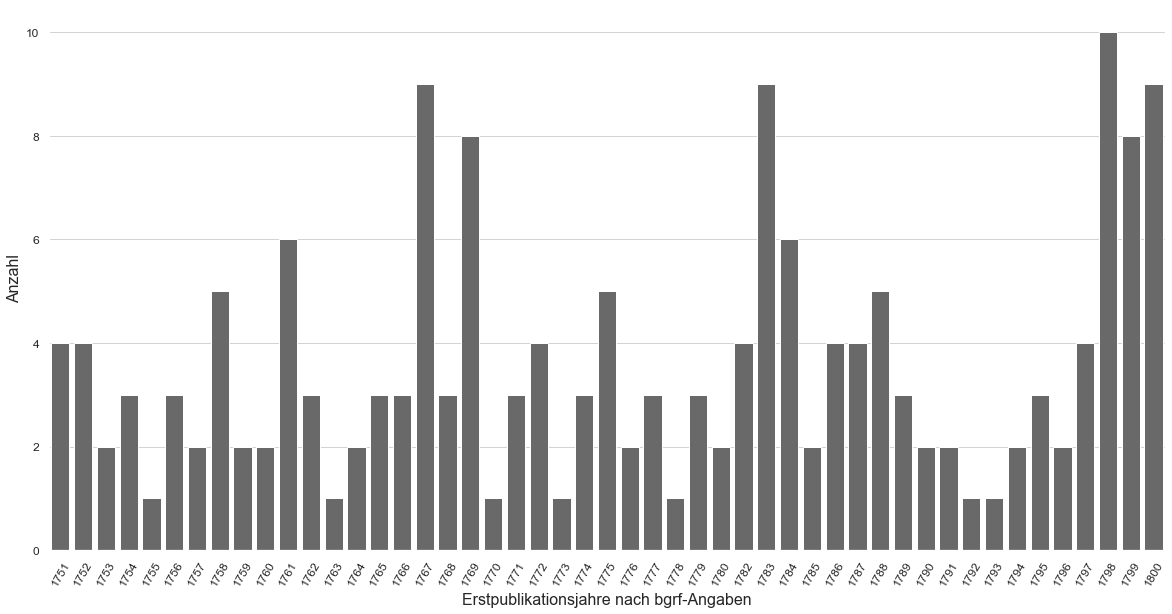

In [461]:
## Visualization of first year of publication in metadata

## Erstpublikation nach firsted-yr
firsted_corpus_sorted_yr = corpus["firsted-yr"]
firsted_corpus_sorted_yr = firsted_corpus_sorted_yr.drop(index=list(firsted_corpus_sorted_yr[firsted_corpus_sorted_yr=="nan"].index)).sort_values()

## Erstpublikation nach bgrf-Angabe in metadaten:
firsted_corpus_sorted_bgrf = corpus["bgrf_year"].sort_values()
firsted_corpus_sorted_bgrf = firsted_corpus_sorted_bgrf.drop(index=list(firsted_corpus_sorted_bgrf[firsted_corpus_sorted_bgrf==1801].index)).sort_values()

def get_countplot_first_pub(df, col):

    fig, ax = plt.subplots(figsize=(20,10))

    sns.countplot(x=df, color="dimgrey")
    ax.set_facecolor(color="white")
    plt.xticks(rotation = 60, fontsize=12)
    plt.yticks(fontsize=12)
 
    plt.ylabel("Anzahl", fontsize=16)
    plt.grid(color="lightgrey", axis='y')

    if col == "bgrf":
        plt.xlabel("Erstpublikationsjahre nach bgrf-Angaben", fontsize=16)
    else:
        plt.xlabel("Erstpublikationsjahre nach firsted-yr", fontsize=16)
    #plt.savefig("Erstpublikationsjahre_grey.png", dpi=300)
#get_countplot_first_pub(firsted_corpus_sorted_yr, "first-yr")
get_countplot_first_pub(firsted_corpus_sorted_bgrf, "bgrf")

#### Vergleich zwischen des Erstpublikationsdatums zwischen firsted-yr und bgrf-Angaben in Metadaten

Zunächst muss überprüft werden, wie viele Texte im Korpus über eine bgrf verfügen (nicht alle besitzen eine, da einige Werke ins Korpus aufgenommen wurden, die die Autor:innen nicht als "roman" gesehen haben)

In [462]:
print("Number of texts in corpus: ", len(corpus))
corpus = corpus.drop(corpus[(corpus["bgrf"] == "0") | (corpus["bgrf"] == "1")].index)
print("Number of texts that do have a bgrf-id: ", len(corpus))

corpus = corpus.sort_values(by=["bgrf"])

Number of texts in corpus:  179
Number of texts that do have a bgrf-id:  175


How many of those to not correlate?

In [463]:
not_machting_counter = 0
for i, row in corpus.iterrows():
    if row["firsted-yr"] != "nan" and int(row["firsted-yr"]) != row["bgrf_year"]:
        not_machting_counter += 1
print("number of texts that don't have matching bgrf and firsted-yr first year publications: ", not_machting_counter)

number of texts that don't have matching bgrf and firsted-yr first year publications:  34


#### Visualization of publication year in corpus

120          NaT
123   1800-01-01
122   1800-01-01
127   1800-01-01
149   1799-01-01
Name: firsted-yr, dtype: datetime64[ns]

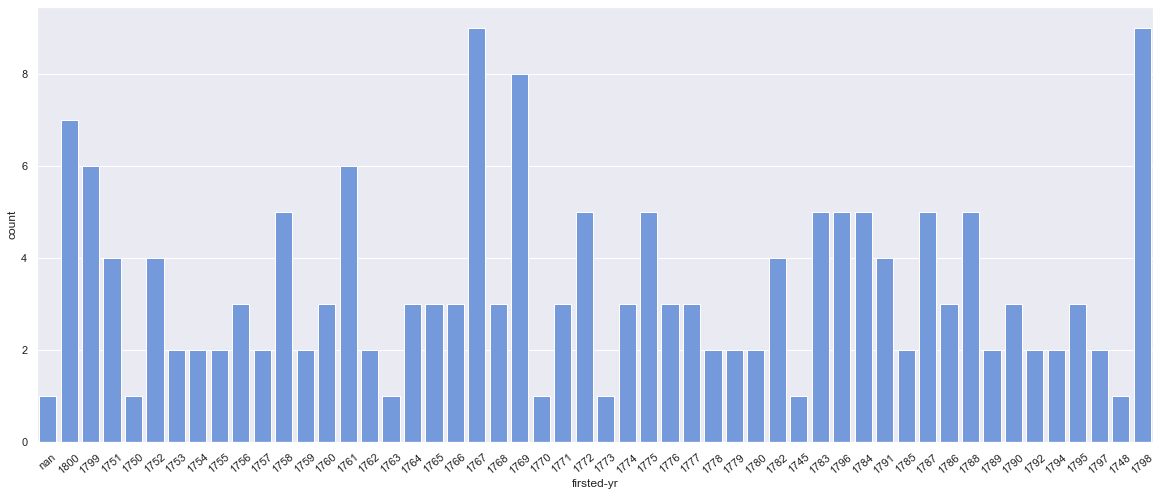

In [464]:
pubyear = pd.to_datetime(corpus['firsted-yr'], format='%Y')

time_range = pubyear.max().year - pubyear.min().year
#plot = sns.displot(x=pubyear, bins=time_range, height=5, aspect=16/8)


fig, ax = plt.subplots(figsize=(20,8))
plot = sns.countplot(x=corpus["firsted-yr"], color="cornflowerblue")
plt.xticks(rotation=40)
#plot.set_xticklabels(rotation=90)
pubyear.head()


### Publication Date (BGRF)

Index(['filename', 'au-name', 'title', 'au-gender', 'firsted-yr',
       'printSource-yr', 'form', 'token count', 'size', 'bgrf',
       'printSource_pubPlace', 'printSource_date', 'origin', 'gender',
       'bgrf_year', 'year', 'page_count.value', 'bgrf_id.value',
       'authorLabel.value', 'narrLabel.value', 'decade'],
      dtype='object')


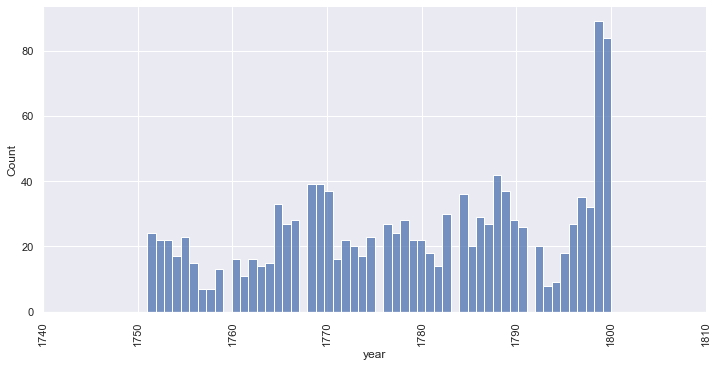

In [465]:
# Publication date

print(combined.columns)
bgrf = combined[combined["origin"] == "wikibase"]["year"].reset_index()
year_range = bgrf['year'].max() - bgrf['year'].min()
plot = sns.displot(x=bgrf['year'], bins=time_range, height=5, aspect=16/8)
plot.set_xticklabels(rotation=90)

### Comparison Publication Date

In [466]:
# Publication year of corpus texts:
year_corpus = pd.to_datetime(corpus['firsted-yr'], format='%Y')

# Publication year of BGRF items:
print(bgrf.columns)
year_bgrf = pd.to_datetime(bgrf['year'], format='%Y')

# Create a date index which includes the whole data range
# so that we can fill in missing data points.
idx = pd.date_range(start='1730', end='1800', freq='YS', closed=None)

# In previous visualizations we have used absolute value counts.
# For comparison we obviously need to use relative frequencies instead.
df = pd.DataFrame(index=idx)
df['freq_corpus'] = year_corpus.value_counts(normalize=True)
print(df)
df['freq_bgrf'] = year_bgrf.value_counts(normalize=True)
df['year'] = df.index.year
print('The data in "wide form"\n', df.head(4), '\n')

# For the visualization we need the data in "long form", i.e. all the
# relative frequencies are in one single column, with another column 
# specifying whether it stems from the corpus or the bibliography.
long = pd.melt(
    df, id_vars=['year'], value_vars=['freq_corpus', 'freq_bgrf'],
    var_name='origin', value_name='rel_freq')

print('The data in "long form"\n', long.head(4))

Index(['index', 'year'], dtype='object')
            freq_corpus
1730-01-01          NaN
1731-01-01          NaN
1732-01-01          NaN
1733-01-01          NaN
1734-01-01          NaN
...                 ...
1796-01-01     0.028736
1797-01-01     0.011494
1798-01-01     0.051724
1799-01-01     0.034483
1800-01-01     0.040230

[71 rows x 1 columns]
The data in "wide form"
             freq_corpus  freq_bgrf  year
1730-01-01          NaN        NaN  1730
1731-01-01          NaN        NaN  1731
1732-01-01          NaN        NaN  1732
1733-01-01          NaN        NaN  1733 

The data in "long form"
    year       origin  rel_freq
0  1730  freq_corpus       NaN
1  1731  freq_corpus       NaN
2  1732  freq_corpus       NaN
3  1733  freq_corpus       NaN


C:\Users\Administrator\AppData\Local\Temp\ipykernel_15448\1970286180.py:10: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  idx = pd.date_range(start='1730', end='1800', freq='YS', closed=None)


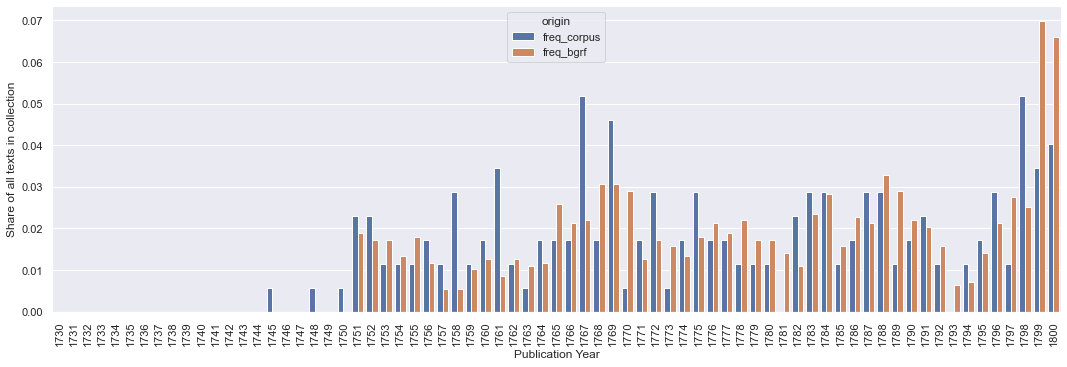

In [467]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long, height=5, aspect=3, legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts in collection')
_ = plt.xticks(rotation=90)

The outlier with publication year 1731 makes the above chart a bit harder to read than necessary. So let's create the same graph with data starting at 1751.

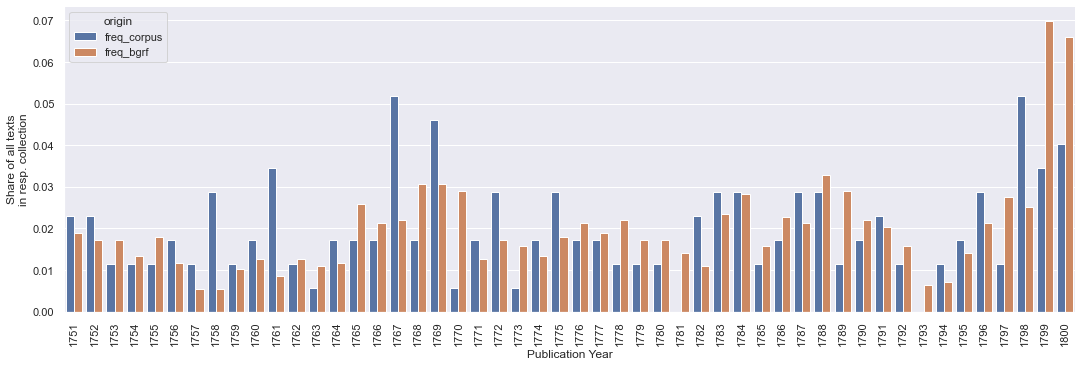

In [468]:
sns.catplot(x='year', y='rel_freq', hue='origin', kind='bar', data=long[long['year'] > 1750], height=5, aspect=3,
           legend_out=False)
plt.xlabel('Publication Year')
plt.ylabel('Share of all texts\nin resp. collection')
_ = plt.xticks(rotation=90)

chosen year:  bgrf_year


Text(0, 0.5, 'percentage')

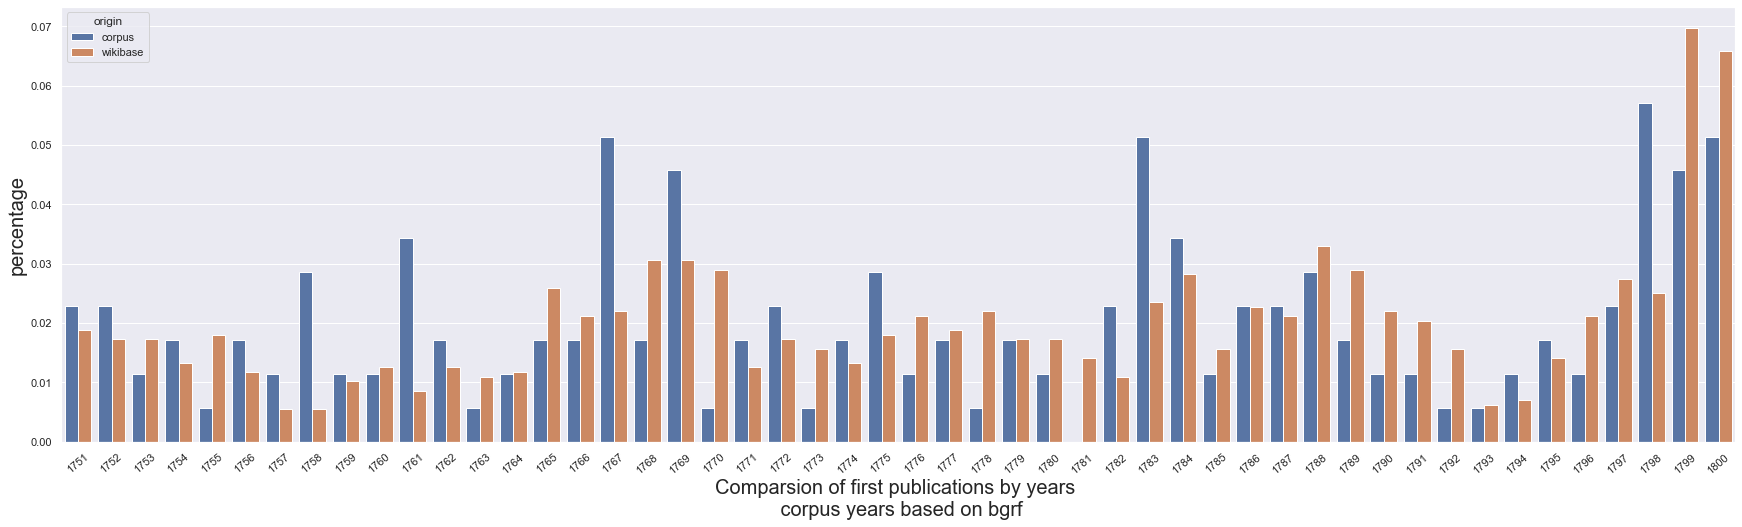

In [470]:
print("chosen year: ", years_chosen)
pubyears = combined[["origin", "year"]]
pubyears = pubyears.drop(pubyears[pubyears["year"] == 1801].index)
pubyears_grouped = pubyears.groupby(["origin"]).value_counts(normalize=True).reset_index(name="percentage")


# sort for years for visualization
years = sorted(set(pubyears["year"]))
fig, ax = plt.subplots(figsize=(30,8))
ax = sns.barplot(x="year", y="percentage", hue="origin", data=pubyears_grouped, order = years)
plt.xticks(rotation=40)
plt.xlabel("Comparsion of first publications by years \n corpus years based on bgrf", fontsize=20)
plt.ylabel("percentage", fontsize=20)

## Narrative Form

### Narrative form corpus
Data is in the column 'form'. Possible values include `'mixed'`, `'autodiegetic'`, `'heterodiegetic'`, `'homodiegetic'`, `'epistolary'`, `'dialogue novel'` and also `NaN`.

Set of all values:  {'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic', 'dialogue novel', 'unknown', 'epistolary'}
% of mixed: 	0.046
% of autodiegetic: 	0.257
% of heterodiegetic: 	0.434
% of homodiegetic: 	0.017
% of epistolary: 	0.200
% of dialogue novel: 	0.034


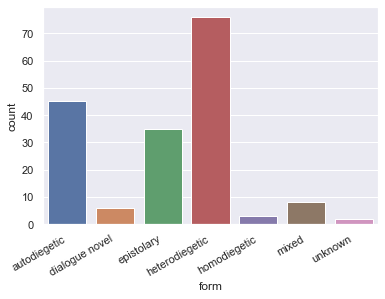

In [157]:
form = corpus['form'].astype('category')
print('Set of all values: ', set(form.values))
print('\n'.join([
    f'% of {kind}: \t{((form==kind).sum()/form.count()):.3f}'
    for kind in [
        'mixed', 'autodiegetic', 'heterodiegetic', 'homodiegetic',
        'epistolary', 'dialogue novel'
    ]
]))
plot = sns.countplot(x=form)
_ = plt.xticks(rotation=30, horizontalalignment='right')

### Narrative Form (BGRF)

In the wikibase data some of the narrative forms are written a little different like dialogue novel vs. dialugue. In order to compare both the Wikibase-Data and the Metadata we will have to align those.

In [158]:
print(combined.groupby(["origin", "form"])["form"].count())

combined["form"] = combined["form"].map(lambda x: "dialogue novel" if x == "dialogue" else x)

origin    form          
corpus    autodiegetic       45
          dialogue novel      7
          epistolary         35
          heterodiegetic     79
          homodiegetic        3
          mixed               8
          unknown             2
wikibase  autodiegetic      256
          dialogue            3
          epistolary        146
          heterodiegetic    464
          homodiegetic       11
          mixed              34
          unknown           266
Name: form, dtype: int64


In [159]:
narrform_bgrf = combined[combined["origin"] == "wikibase"]["form"].reset_index()

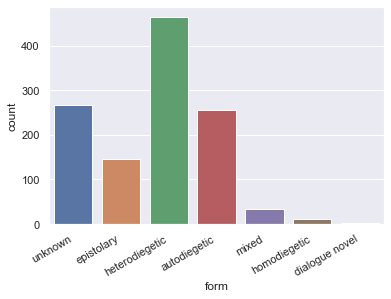

In [160]:
plot = sns.countplot(x=narrform_bgrf['form'])
_ = plt.xticks(rotation=30, horizontalalignment='right')

## Comparison

### Narrative Form (Corpus vs BGRF)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15448\4175754276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  narr_form_combined["fy"] = combined["form"] + "-" + combined["decade"]


      origin  decade            form                     fy  percentage
0     corpus  1750er  heterodiegetic  heterodiegetic-1750er    0.461538
1     corpus  1750er    autodiegetic    autodiegetic-1750er    0.269231
2     corpus  1750er      epistolary      epistolary-1750er    0.153846
3     corpus  1750er           mixed           mixed-1750er    0.076923
4     corpus  1750er  dialogue novel  dialogue novel-1750er    0.038462
..       ...     ...             ...                    ...         ...
60  wikibase    1800  heterodiegetic    heterodiegetic-1800    0.422535
61  wikibase    1800    autodiegetic      autodiegetic-1800    0.239437
62  wikibase    1800         unknown           unknown-1800    0.183099
63  wikibase    1800      epistolary        epistolary-1800    0.112676
64  wikibase    1800           mixed             mixed-1800    0.042254

[65 rows x 5 columns]


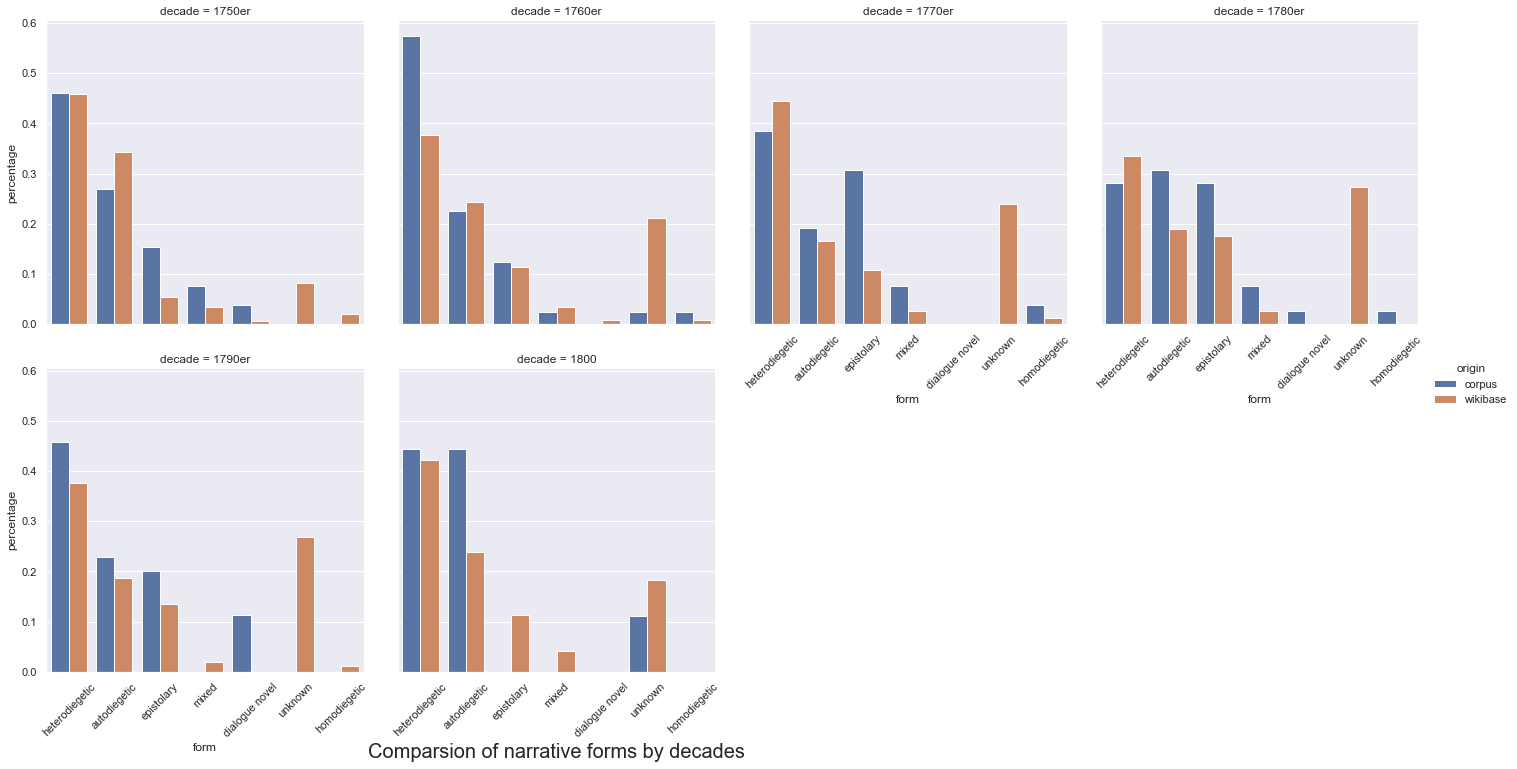

In [161]:
## comparison of the narrative forms by decade
narr_form_combined = combined[["form", "decade", "origin"]]

narr_form_combined["fy"] = combined["form"] + "-" + combined["decade"]

narr_form_grouped = narr_form_combined.groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
print(narr_form_grouped)

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin",col_wrap=4, data=narr_form_grouped, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparsion of narrative forms by decades", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

      origin  decade            form                     fy  percentage
0     corpus  1750er  heterodiegetic  heterodiegetic-1750er    0.461538
1     corpus  1750er    autodiegetic    autodiegetic-1750er    0.269231
2     corpus  1750er      epistolary      epistolary-1750er    0.153846
3     corpus  1750er           mixed           mixed-1750er    0.076923
4     corpus  1750er  dialogue novel  dialogue novel-1750er    0.038462
5     corpus  1760er  heterodiegetic  heterodiegetic-1760er    0.589744
6     corpus  1760er    autodiegetic    autodiegetic-1760er    0.230769
7     corpus  1760er      epistolary      epistolary-1760er    0.128205
8     corpus  1760er           mixed           mixed-1760er    0.025641
9     corpus  1760er    homodiegetic    homodiegetic-1760er    0.025641
10    corpus  1770er  heterodiegetic  heterodiegetic-1770er    0.384615
11    corpus  1770er      epistolary      epistolary-1770er    0.307692
12    corpus  1770er    autodiegetic    autodiegetic-1770er    0

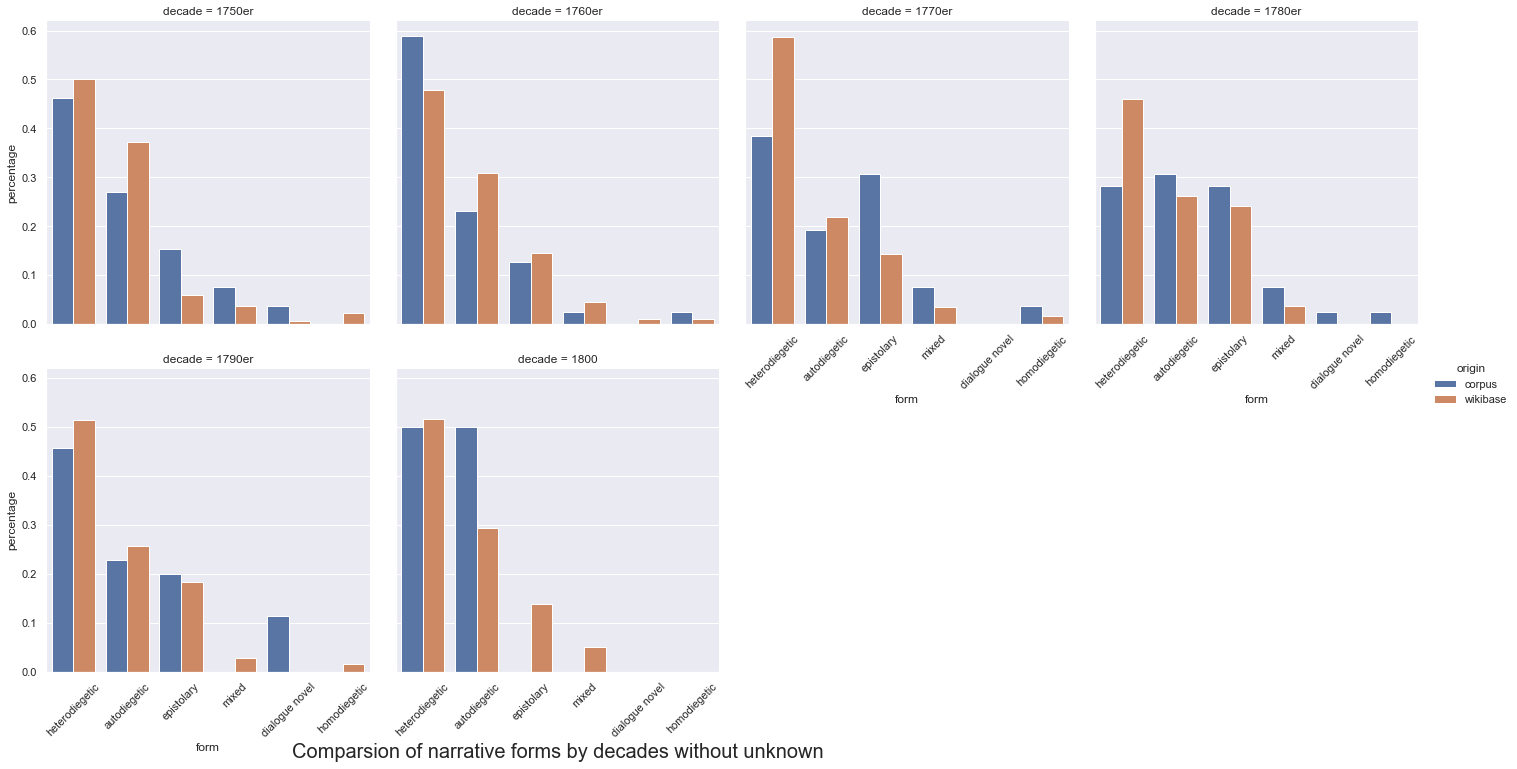

In [162]:
## drop unknown:

narr_form_combined_wo_unknown = narr_form_combined.drop(narr_form_combined[(narr_form_combined["form"] == "unknown")].index)
narr_form_grouped_wo_unknwon = narr_form_combined_wo_unknown.groupby(["origin", "decade"]).value_counts(normalize=True).reset_index(name="percentage")
print(narr_form_grouped_wo_unknwon)

ax = sns.catplot(x="form", y="percentage", col="decade", hue="origin",col_wrap=4, data=narr_form_grouped_wo_unknwon, kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Comparsion of narrative forms by decades without unknown", fontsize=20)
plt.ylabel("percentage", fontsize=20)
ax.set_xticklabels(rotation=45)

    gender            form      perc
0   female      epistolary  0.566667
1   female  heterodiegetic  0.300000
2   female    autodiegetic  0.033333
3   female  dialogue novel  0.033333
4   female           mixed  0.033333
5   female         unknown  0.033333
6     male  heterodiegetic  0.472603
7     male    autodiegetic  0.287671
8     male      epistolary  0.123288
9     male           mixed  0.047945
10    male  dialogue novel  0.041096
11    male    homodiegetic  0.020548
12    male         unknown  0.006849


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'epistolary'),
  Text(1, 0, 'heterodiegetic'),
  Text(2, 0, 'autodiegetic'),
  Text(3, 0, 'dialogue novel'),
  Text(4, 0, 'mixed'),
  Text(5, 0, 'unknown'),
  Text(6, 0, 'homodiegetic')])

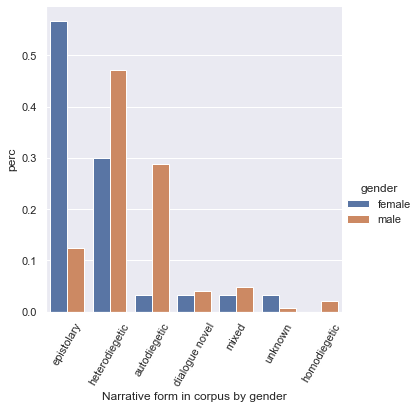

In [163]:
authors_narr_grouped = combined[combined["origin"] == "corpus"][["form", "gender"]]

#authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["form"] == "unknown")].index)
authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["gender"] == "unknown")].index)

authors_narr_grouped = authors_narr_grouped.groupby(["gender"]).value_counts(normalize=True).reset_index(name="perc")
print(authors_narr_grouped)

ax = sns.catplot(x="form", y="perc",  hue="gender", data=authors_narr_grouped, kind="bar")
plt.xlabel("Narrative form in corpus by gender")
plt.xticks(rotation=60)

    gender            form      perc
0   female  heterodiegetic  0.380090
1   female      epistolary  0.235294
2   female         unknown  0.212670
3   female    autodiegetic  0.122172
4   female           mixed  0.040724
5   female  dialogue novel  0.004525
6   female    homodiegetic  0.004525
7     male  heterodiegetic  0.394517
8     male         unknown  0.243147
9     male    autodiegetic  0.230036
10    male      epistolary  0.092968
11    male           mixed  0.028605
12    male    homodiegetic  0.008343
13    male  dialogue novel  0.002384


(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'heterodiegetic'),
  Text(1, 0, 'epistolary'),
  Text(2, 0, 'unknown'),
  Text(3, 0, 'autodiegetic'),
  Text(4, 0, 'mixed'),
  Text(5, 0, 'dialogue novel'),
  Text(6, 0, 'homodiegetic')])

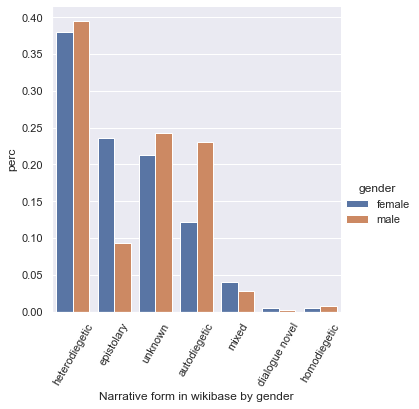

In [164]:
authors_narr_grouped_w = combined[combined["origin"] == "wikibase"][["form", "gender"]]

#authors_narr_grouped = authors_narr_grouped.drop(authors_narr_grouped[(authors_narr_grouped["form"] == "unknown")].index)
authors_narr_grouped_w = authors_narr_grouped_w.drop(authors_narr_grouped_w[(authors_narr_grouped_w["gender"] == "unknown")].index)

authors_narr_grouped_w = authors_narr_grouped_w.groupby(["gender"]).value_counts(normalize=True).reset_index(name="perc")
print(authors_narr_grouped_w)

ax = sns.catplot(x="form", y="perc",  hue="gender", data=authors_narr_grouped_w, kind="bar")
plt.xlabel("Narrative form in wikibase by gender")
plt.xticks(rotation=60)